In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wrangle import *
from explore import *

# modeling methods
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = acquire_zillow()

In [3]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,latitude,longitude,lotsizesquarefeet,garagecarcnt
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,Condominium,2017-08-04,33922098.0,-117954970.0,NaN,1.0
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21,34033180.0,-118355396.0,5672.0,NaN
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,Single Family Residential,2017-06-23,34686163.0,-118113100.0,8284.0,NaN
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,Condominium,2017-07-28,34073222.0,-118390965.0,25082.0,NaN
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30,33999877.0,-118291863.0,6707.0,NaN


In [4]:
df.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'taxamount',
       'fips', 'propertylandusedesc', 'transactiondate', 'latitude',
       'longitude', 'lotsizesquarefeet', 'garagecarcnt'],
      dtype='object')

In [5]:
df.fips.value_counts()

6037.0    24052
6059.0    11141
6111.0     3389
Name: fips, dtype: int64

In [6]:
# Converting fips to actual county name

df['county'] = df['fips'].replace({6037:'Los Angeles',6059:'Orange',6111:'Ventura'})

In [7]:
# Creating tax_rate column

df['tax_rate'] = round((df['taxamount']/df['tax_value'])*100,2)
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,latitude,longitude,lotsizesquarefeet,garagecarcnt,county,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,Condominium,2017-08-04,33922098.0,-117954970.0,NaN,1.0,Orange,1.21
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21,34033180.0,-118355396.0,5672.0,NaN,Los Angeles,1.28
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,Single Family Residential,2017-06-23,34686163.0,-118113100.0,8284.0,NaN,Los Angeles,1.70
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,Condominium,2017-07-28,34073222.0,-118390965.0,25082.0,NaN,Los Angeles,1.16
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30,33999877.0,-118291863.0,6707.0,NaN,Los Angeles,1.53


In [8]:
# Remove Outliers

col_list = ['bedrooms','bathrooms','area','tax_value','taxamount','tax_rate']
df = remove_outliers(df,1.5,col_list)

In [9]:
# Imputing year_built with most_frequent value

imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(df[['year_built']])
df[['year_built']] = imputer.transform(df[['year_built']])

In [10]:
df.isnull().any()

bedrooms               False
bathrooms              False
area                   False
tax_value              False
year_built             False
taxamount              False
fips                   False
propertylandusedesc    False
transactiondate        False
latitude               False
longitude              False
lotsizesquarefeet       True
garagecarcnt            True
county                 False
tax_rate               False
dtype: bool

In [11]:
df.shape

(30347, 15)

In [12]:
# Creating a dataframe with county and tax_rate
tax_data = pd.DataFrame({'county':df.county,'tax_rate':df.tax_rate})
tax_data

,county,tax_rate
0,Orange,1.21
1,Los Angeles,1.28
3,Los Angeles,1.16
4,Los Angeles,1.53
5,Orange,1.12
...,...,...
38575,Los Angeles,1.21
38576,Orange,1.19
38578,Los Angeles,1.22
38579,Los Angeles,1.21


In [13]:
tax_data.describe()

,tax_rate
count,30347.000000
mean,1.234090
std,0.132689
min,0.900000
25%,1.160000
50%,1.220000
75%,1.290000
max,1.620000


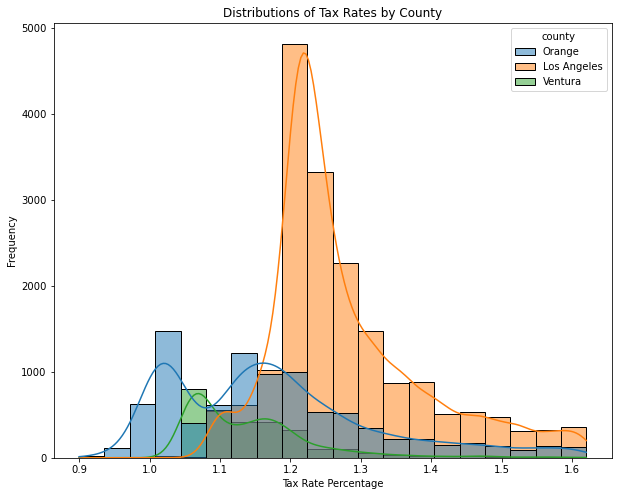

In [14]:
plt.figure(figsize=(10,8))
sns.histplot(data=tax_data, x='tax_rate', kde=True, hue='county', bins=20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Tax Rate Percentage')
plt.ylabel('Frequency')
plt.title('Distributions of Tax Rates by County')
plt.show()

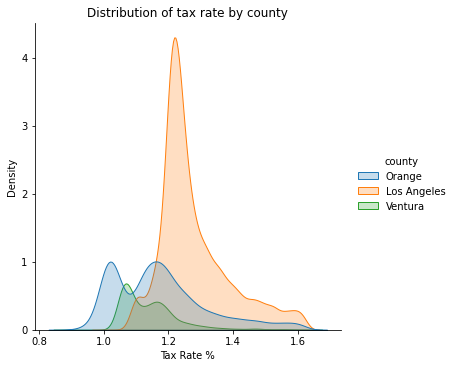

In [15]:
# Plotting distribution of tax_rate by county

sns.displot(tax_data, x="tax_rate", hue="county", kind='kde',fill=True)
plt.xlabel('Tax Rate %')
plt.title('Distribution of tax rate by county')
plt.show()

In [16]:
df[df.county=='Los Angeles'].tax_rate.mean()

1.2778281726995002

In [17]:
df[df.county=='Orange'].tax_rate.mean()

1.1750417582417736

In [18]:
df[df.county=='Ventura'].tax_rate.mean()

1.142803995866346

In [19]:
df.corr()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,latitude,longitude,lotsizesquarefeet,garagecarcnt,tax_rate
bedrooms,1.000000,0.511702,0.685406,0.216183,0.024449,0.220372,0.125623,0.069646,0.000997,-0.142895,0.385046,0.012255
bathrooms,0.511702,1.000000,0.693307,0.340512,0.450688,0.341423,0.074106,0.038511,0.007515,0.021913,0.391184,-0.097575
area,0.685406,0.693307,1.000000,0.417961,0.209260,0.414338,0.121745,0.043851,0.013392,-0.092155,0.457240,-0.087633
tax_value,0.216183,0.340512,0.417961,1.000000,0.206259,0.982303,0.070283,-0.131329,0.041118,-0.061356,0.243122,-0.418194
year_built,0.024449,0.450688,0.209260,0.206259,1.000000,0.202514,0.239073,-0.059568,0.072909,0.135585,0.109982,-0.140022
taxamount,0.220372,0.341423,0.414338,0.982303,0.202514,1.000000,0.007896,-0.072734,0.024145,-0.051609,0.239684,-0.272915
fips,0.125623,0.074106,0.121745,0.070283,0.239073,0.007896,1.000000,-0.009156,-0.368685,-0.109303,0.054908,-0.355572
latitude,0.069646,0.038511,0.043851,-0.131329,-0.059568,-0.072734,-0.009156,1.000000,-0.671030,0.096999,0.073033,0.309818
longitude,0.000997,0.007515,0.013392,0.041118,0.072909,0.024145,-0.368685,-0.671030,1.000000,-0.053717,-0.037938,-0.046155
lotsizesquarefeet,-0.142895,0.021913,-0.092155,-0.061356,0.135585,-0.051609,-0.109303,0.096999,-0.053717,1.000000,0.016979,0.059635


In [20]:
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,latitude,longitude,lotsizesquarefeet,garagecarcnt,county,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,Condominium,2017-08-04,33922098.0,-117954970.0,NaN,1.0,Orange,1.21
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21,34033180.0,-118355396.0,5672.0,NaN,Los Angeles,1.28
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,Condominium,2017-07-28,34073222.0,-118390965.0,25082.0,NaN,Los Angeles,1.16
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30,33999877.0,-118291863.0,6707.0,NaN,Los Angeles,1.53
5,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,Single Family Residential,2017-06-01,33694636.0,-117912245.0,4975.0,2.0,Orange,1.12


In [21]:
# Splitting Data for Exploration
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [22]:
train.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built', 'taxamount',
       'fips', 'propertylandusedesc', 'transactiondate', 'latitude',
       'longitude', 'lotsizesquarefeet', 'garagecarcnt', 'county', 'tax_rate'],
      dtype='object')

In [23]:
#cat_vars = ['bedrooms','bathrooms','county','fips']
#quant_vars = ['area','tax_rate']

#explore_bivariate(train, 'tax_value', cat_vars, quant_vars)

#### Hypothesis 1
#### Is there a correlation between area and tax_value?
"$H_0$ = Tax_value is independent of area"

"$H_a$ = Tax_value and area are dependent on each other."

In [24]:
alpha = .05

In [25]:
r, p = stats.pearsonr(train.area, train.tax_value)
print(f'The p-value is: {p}. There is {round(p,3)}% chance that we see these results by chance.')
print(f'r = {round(r, 2)}')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.41


#### Hypothesis 2
#### Is the tax_rate mean different between LA county vs Ventury and Orange counties?
"$H_0$ = Tax_rate in LA county is not different than the mean rates in Ventura and Orange counties."

"$H_a$ = Tax_rate in LA county is different than the mean rates in Ventura and Orange counties."

In [26]:
stats.mannwhitneyu(train[train['county']== 'Los Angeles']['tax_value'], train[train['county'] != 'Los Angeles']['tax_value'])

MannwhitneyuResult(statistic=29429180.5, pvalue=1.0840152042230447e-59)

We reject the null hypothesis

#### Hypothesis 3
#### Is the tax_rate mean different between Ventura county vs LA and Orange counties?
"$H_0$ = Tax_rate in Ventura county is not different than the mean rates in LA and Orange counties."

"$H_a$ = Tax_rate in Ventura county is different than the mean rates in LA and Orange counties."

In [27]:
stats.mannwhitneyu(train[train['county']== 'Ventura']['tax_value'], train[train['county'] != 'Ventura']['tax_value'])

MannwhitneyuResult(statistic=12048297.0, pvalue=0.0028976702431205304)

We reject the null hypothesis

#### Hypothesis 4
#### Is the tax_rate mean different between Orange county vs LA and Ventura counties?
"$H_0$ = Tax_rate in Orange county is not different than the mean rates in LA and Ventura counties."

"$H_a$ = Tax_rate in Orange county is different than the mean rates in LA and Ventura counties."

In [28]:
stats.mannwhitneyu(train[train['county']== 'Orange']['tax_value'], train[train['county'] != 'Orange']['tax_value'])

MannwhitneyuResult(statistic=25695206.5, pvalue=5.0906743383076545e-55)

We reject the null hypothesis

In [29]:
tax_and_date = pd.DataFrame({'tax_value':df.tax_value,'transactiondate':df.transactiondate})
tax_and_date

,tax_value,transactiondate
0,289445.0,2017-08-04
1,205123.0,2017-07-21
3,810694.0,2017-07-28
4,35606.0,2017-06-30
5,880456.0,2017-06-01
...,...,...
38575,119659.0,2017-08-31
38576,465999.0,2017-08-31
38578,492395.0,2017-08-31
38579,600608.0,2017-08-31


In [30]:
tax_and_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30347 entries, 0 to 38581
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tax_value        30347 non-null  float64
 1   transactiondate  30347 non-null  object 
dtypes: float64(1), object(1)
memory usage: 711.3+ KB


In [31]:
# Create a month column:
conditions =[
    (df.transactiondate.str.match('2017-05')),
    (df.transactiondate.str.match('2017-06')),
    (df.transactiondate.str.match('2017-07')),
    (df.transactiondate.str.match('2017-08'))]

values = ['May','June','July','August']

df['month'] = np.select(conditions, values)

conditions2 = [
    (df.month.str.match('May')),
    (df.month.str.match('June')),
    (df.month.str.match('July')),
    (df.month.str.match('August'))]

values2 = [1,2,3,4]

df['month_encoded'] = np.select(conditions2,values2)

df.head()

,bedrooms,bathrooms,area,tax_value,year_built,taxamount,fips,propertylandusedesc,transactiondate,latitude,longitude,lotsizesquarefeet,garagecarcnt,county,tax_rate,month,month_encoded
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,Condominium,2017-08-04,33922098.0,-117954970.0,NaN,1.0,Orange,1.21,August,4
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,Single Family Residential,2017-07-21,34033180.0,-118355396.0,5672.0,NaN,Los Angeles,1.28,July,3
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,Condominium,2017-07-28,34073222.0,-118390965.0,25082.0,NaN,Los Angeles,1.16,July,3
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,Single Family Residential,2017-06-30,33999877.0,-118291863.0,6707.0,NaN,Los Angeles,1.53,June,2
5,4.0,3.0,2541.0,880456.0,2003.0,9819.72,6059.0,Single Family Residential,2017-06-01,33694636.0,-117912245.0,4975.0,2.0,Orange,1.12,June,2


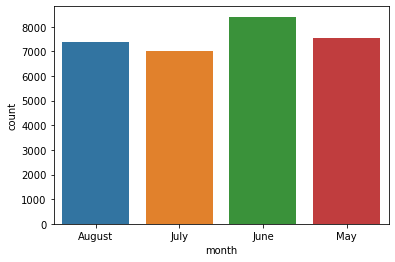

In [32]:
sns.countplot(x=df['month'])
plt.show()

In [33]:
month_value = {'Months':['May','June','July','August'],\
                'tax_value_mean':[(df[df.month=='May'].tax_value.mean()),\
                                  (df[df.month=='June'].tax_value.mean()),\
                                    (df[df.month=='July'].tax_value.mean()),\
                                    (df[df.month=='August'].tax_value.mean())],
              'tax_amount_mean':[(df[df.month=='May'].taxamount.mean()),\
                                  (df[df.month=='June'].taxamount.mean()),\
                                    (df[df.month=='July'].taxamount.mean()),\
                                    (df[df.month=='August'].taxamount.mean())],
              'tax_rate_mean': [(df[df.month=='May'].tax_rate.mean()),\
                                  (df[df.month=='June'].tax_rate.mean()),\
                                    (df[df.month=='July'].tax_rate.mean()),\
                                    (df[df.month=='August'].tax_rate.mean())]}
               
               
month_value_df = pd.DataFrame(data=month_value)

month_value_df

,Months,tax_value_mean,tax_amount_mean,tax_rate_mean
0,May,378754.909151,4555.928423,1.234188
1,June,383206.199905,4619.350295,1.235834
2,July,378006.875606,4551.014098,1.233080
3,August,373581.788584,4493.087396,1.232964


<AxesSubplot:xlabel='Months', ylabel='tax_amount_mean'>

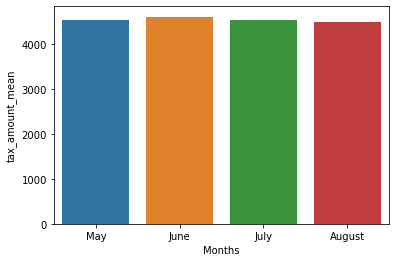

In [34]:
sns.barplot(x='Months',y='tax_amount_mean',data=month_value_df)

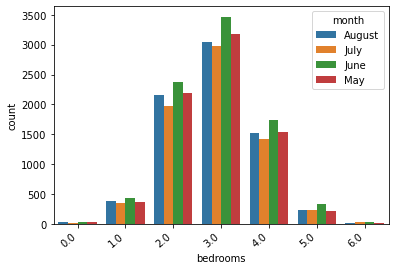

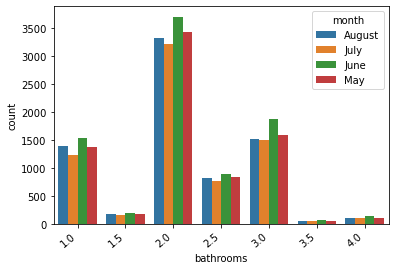

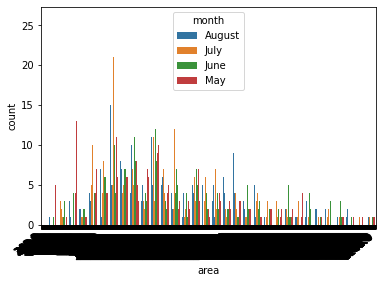

In [ ]:
for col in df.columns:
    ax = sns.countplot(x=df[col], hue='month', data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.show()